# Analyzing the embeddings

This notebook pretends to analyze the output of the get_embeddings script evaluating them with a dataset

In [6]:
# Library imports
import os
import glob

import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from sentence_transformers import util

In [7]:
# Global variables
MODEL = 'Qwen/Qwen3-Embedding-8B'
DATA_PATH = '../data'
DATA_EMBEDDINGS_PATH = f'../data_embeddings_transformers/{MODEL}'
DATASET_EMBEDDINGS_PATH = f'../dataset_embeddings_transformers/{MODEL}'
DATASET_NAME = 'Rivert97/ug-normativity'

In [8]:
# Loading questions dataset
dataset = load_dataset(DATASET_NAME)
dataset = dataset['train']

In [9]:
dataset

Dataset({
    features: ['id', 'title', 'context', 'additional_context', 'question', 'answers'],
    num_rows: 1836
})

In [10]:
all_data = []
all_embeddings = []
all_questions_embeddings = []
file_excludes = ['reglamento-de-responsabilidades-en-el-entorno-universitario-de-la-universidad-de-guanajuato']

# Loading the data
for data_filename in glob.glob(os.path.join(DATA_PATH, '*.csv')):
    embeddings_filename = os.path.join(DATA_EMBEDDINGS_PATH, os.path.split(data_filename)[1])
    questions_filename = os.path.join(DATASET_EMBEDDINGS_PATH, os.path.split(data_filename)[1])

    if not os.path.exists(questions_filename):
        print(f"Ignoring file {data_filename}")
        file_excludes.append(os.path.splitext(os.path.split(data_filename)[1])[0])
        continue

    data = pd.read_csv(data_filename, sep=',')
    embeddings = pd.read_csv(embeddings_filename, sep=',', index_col=0)
    questions_embeddings = pd.read_csv(questions_filename, sep=',', index_col=0)

    all_data.append(data)
    all_embeddings.append(embeddings)
    all_questions_embeddings.append(questions_embeddings)

data = pd.concat(all_data, ignore_index=True)
embeddings = pd.concat(all_embeddings, ignore_index=True)
questions_embeddings = pd.concat(all_questions_embeddings)


Ignoring file ../data/modelo-educativo-de-la-universidad-de-guanajuato-y-su-modelo-academico-ug.csv
Ignoring file ../data/reglameto-de-responsabilidades-en-el-entorno-universitario-de-la-universidad-de-guanajuato.csv


In [11]:
embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,-0.005215,-0.010687,-0.038705,0.006419,0.009421,0.017772,-0.025534,0.020897,-0.041805,0.010148,...,-0.008674,0.003909,0.005828,-0.004547,-0.000780,0.009028,0.001117,0.013285,0.003420,-0.020078
1,-0.019379,-0.005820,-0.039835,0.005481,-0.004759,0.026998,-0.031467,0.030047,-0.047916,-0.002034,...,-0.004795,0.002508,0.023576,0.006309,0.008229,-0.002107,0.003453,0.018306,0.006792,-0.027780
2,-0.011586,-0.000128,-0.042064,0.016686,-0.001636,0.010702,-0.005490,0.017494,-0.028888,0.038786,...,-0.019493,-0.009110,0.010431,-0.007999,0.000962,0.014377,0.011607,0.002378,-0.005646,-0.006510
3,-0.003168,0.017321,-0.007981,0.024498,0.007595,0.030051,-0.013475,0.024653,-0.024666,-0.009064,...,-0.005192,0.003752,0.006987,0.007403,0.025833,0.008149,-0.001549,-0.006507,-0.010195,-0.024008
4,0.001943,0.005659,-0.021827,0.015977,0.005368,0.027047,-0.014071,0.011385,-0.009306,0.019806,...,-0.015233,-0.007000,0.016257,0.011784,-0.005826,0.004718,-0.005406,-0.009363,-0.005244,-0.021012


In [12]:
questions_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
81e729afa369916be4d4db99f9c1817c,-0.006412,-0.018319,-0.017593,0.000598,-0.027697,0.028804,-0.001806,0.006148,-0.018103,0.008297,...,-0.009604,0.021714,0.003340,0.009933,-0.010572,0.022439,0.004428,0.006106,0.000345,-0.000577
28738544e42b076370fc813c5711852a,-0.002990,0.004150,0.008023,-0.017578,0.002410,0.002587,-0.010324,0.030940,-0.000117,-0.008271,...,-0.002299,0.017626,-0.022265,-0.010013,-0.012745,-0.010507,-0.011722,0.025940,-0.012291,0.005623
948cb616a68fe33024da19654b56a0b1,-0.005526,0.001185,-0.009786,0.001182,0.007821,0.022519,-0.017428,0.017500,-0.036698,0.010113,...,-0.010469,0.006144,0.000872,0.011159,0.008346,0.008150,-0.014044,-0.019359,-0.007478,-0.000969
e80f3ca8fb8791ca480ee02bf9250484,-0.007725,0.008670,-0.019240,0.016112,-0.017704,-0.001864,-0.031104,0.004306,-0.009911,0.005555,...,0.006107,0.009954,0.014488,-0.009051,0.007103,0.002243,-0.016031,-0.009942,0.000384,-0.012359
c1ca177b00aeae41aa361c243e612a9d,0.002322,0.004278,-0.002284,-0.006067,-0.013963,0.014789,-0.033553,0.005066,0.000689,0.008049,...,-0.011024,-0.005515,0.002737,-0.002870,0.001750,0.006051,-0.009067,-0.018205,0.016716,0.016760


In [13]:
# For each question find its chunk
questions = []

for question in dataset:
    if question['title'] in file_excludes:
        continue

    tmp_question = {
        'question': question,
        'question_embeddings': questions_embeddings.loc[question['id']].values,
        'chunk_idx': None,
        'chunk': None,
        'chunk_embeddings': None,
    }

    for chunk_idx, chunk in data.loc[data['document_name'] == question['title']].iterrows():
        if chunk['path'].lower().endswith(question['context'].lower().strip()):
            tmp_question['chunk_idx'] = chunk_idx
            tmp_question['chunk'] = chunk
            tmp_question['chunk_embeddings'] = embeddings.loc[chunk_idx].values
            break

    if tmp_question['chunk_idx'] is not None:
        questions.append(tmp_question)

print(questions[0])

{'question': {'id': '81e729afa369916be4d4db99f9c1817c', 'title': 'ley-organica-de-la-universidad-de-guanajuato', 'context': 'Artículo 1', 'additional_context': '', 'question': '¿Qué contiene la Ley Orgánica de la Universidad de Guanajuato?', 'answers': {'text': ['Contiene las normas fundamentales de la misión, organización, funcionamiento y gobierno de la Universidad de Guanajuato']}}, 'question_embeddings': array([-0.00641239, -0.01831903, -0.01759305, ...,  0.006106  ,
        0.00034519, -0.00057699], shape=(4096,)), 'chunk_idx': 7, 'chunk': document_name         ley-organica-de-la-universidad-de-guanajuato
title                                                   Artículo 1
path             /root/LEY ORGÁNICA DE LA UNIVERSIDAD DE GUANAJ...
parent                                                  Artículo 1
sentences        La presente Ley es de orden público y de inter...
Name: 7, dtype: object, 'chunk_embeddings': array([-1.7059645e-02,  1.2419661e-02, -1.9840367e-02, ...,
       -1.

Min:  tensor(0.1655, dtype=torch.float64)
Max:  tensor(0.9389, dtype=torch.float64)
Mean:  0.6726797162475533


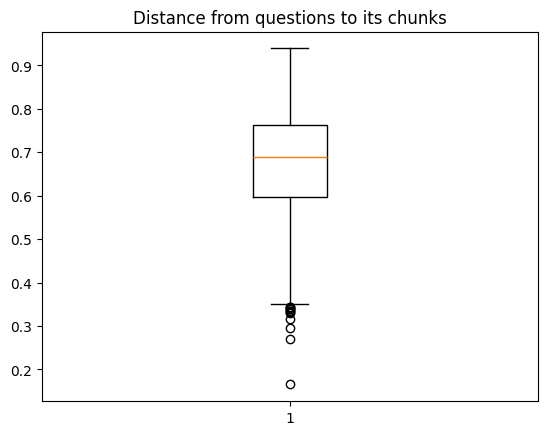

In [14]:
# Analyzing distances between questions and its chunks
distances = []
for question in questions:
    score = util.dot_score(question['question_embeddings'], question['chunk_embeddings'])
    distances.append(score[0][0])

plt.figure()
plt.title("Distance from questions to its chunks")
plt.boxplot(distances)
print("Min: ", min(distances))
print("Max: ", max(distances))
print("Mean: ", np.mean(distances))

Top 5
Min:  0.30708593752322955
Max:  0.9389169842746895
Mean:  0.6031938789932111
Top 5 mean
Min:  0.35981952768950565
Max:  0.8587624488238621
Mean:  0.6031938789932111


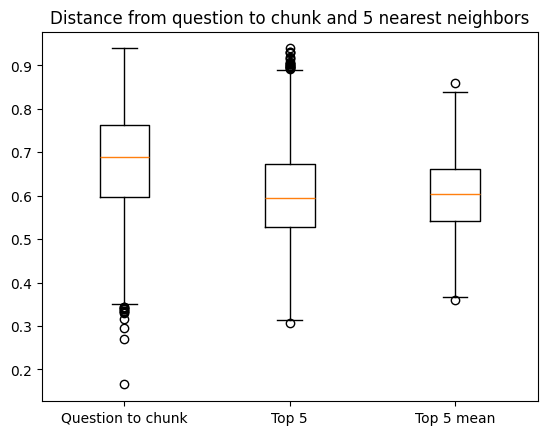

In [15]:
# Analyzing distance from each question to its K neighbors
k = 5
top_k_distances = []
top_k_distances_mean = []
top_k_embeddings_idx = {}
for question in questions:
    scores = util.dot_score(question['question_embeddings'], embeddings.values)[0].tolist()
    doc_score_pairs = list(zip(data.index.tolist(), scores))

    doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)

    dist = [d[1] for d in doc_score_pairs[:k]]
    idx = [d[0] for d in doc_score_pairs[:k]]

    top_k_distances.extend(dist)
    top_k_distances_mean.append(np.mean(dist))
    top_k_embeddings_idx[question['question']['id']] = idx

plt.figure()
plt.title(f"Distance from question to chunk and {k} nearest neighbors")
plt.boxplot((distances, top_k_distances, top_k_distances_mean), tick_labels=['Question to chunk', f'Top {k}', f'Top {k} mean'])
print(f"Top {k}")
print("Min: ", min(top_k_distances))
print("Max: ", max(top_k_distances))
print("Mean: ", np.mean(top_k_distances))
print(f"Top {k} mean")
print("Min: ", min(top_k_distances_mean))
print("Max: ", max(top_k_distances_mean))
print("Mean: ", np.mean(top_k_distances_mean))

# Evaluating with the dataset

In [16]:
# Analyzing percentaje of answers present in K nearest neighbors
count_in_top_k = 0
for question in questions:
    top_k_idx = top_k_embeddings_idx[question['question']['id']]
    if question['chunk_idx'] in top_k_idx:
        count_in_top_k += 1

print(f"% of presence in top {k}: {count_in_top_k/len(questions)}")

% of presence in top 5: 0.9205340114431023


In [17]:
# Obtaining F1@k
metrics = {
    'precisions': np.zeros((len(questions),), dtype=np.float32),
    'recalls': np.zeros((len(questions),), dtype=np.float32),
    'f1s': np.zeros((len(questions),), dtype=np.float32),
}
for q_idx, question in enumerate(questions):
    n_relevant = 0
    top_k_idx = top_k_embeddings_idx[question['question']['id']]
    all_relevant = data[(data['document_name'] == question['question']['title']) & (data['parent'] == question['question']['context'].split('/')[-1])]

    for idx in top_k_idx:
        if data.loc[idx, 'path'].lower().endswith(question['question']['context'].lower()):
            n_relevant += 1

    precision = n_relevant/k
    recall = n_relevant/len(all_relevant) if len(all_relevant) > 0 else 0
    f1 = (2*precision*recall)/(precision+recall) if precision+recall > 0 else 0

    metrics['precisions'][q_idx] = precision
    metrics['recalls'][q_idx] = recall
    metrics['f1s'][q_idx] = f1

print(f"Precision@{k}:", metrics['precisions'].mean())
print(f"Recall@{k}:", metrics['recalls'].mean())
print(f"F1@{k}:", metrics['f1s'].mean())

Precision@5: 0.19872856
Recall@5: 0.9866497
F1@5: 0.3290346


# Evaluating by file

In [18]:
# Analyzing percentaje of answers present in K nearest neighbors
presence_top_k = {}
for file in data['document_name'].unique():
    if file in file_excludes:
        continue

    count_in_top_k = 0
    total_count = 0
    for question in filter(lambda q: q['question']['title'] == file, questions):
        top_k_idx = top_k_embeddings_idx[question['question']['id']]
        if question['chunk_idx'] in top_k_idx:
            count_in_top_k += 1
        total_count += 1

    presence = count_in_top_k/total_count
    print(f"{presence}: {file} % of presence in top {k}")
    presence_top_k[file] = presence


0.9122807017543859: ley-organica-de-la-universidad-de-guanajuato % of presence in top 5
0.9356435643564357: reglamento-del-personal-academico-de-la-universidad-de-guanajuato % of presence in top 5
0.9811320754716981: reglamento-de-distinciones-universitarias-de-la-universidad-de-guanajuato % of presence in top 5
1.0: reglamento-de-la-junta-directiva-de-la-universidad-de-guanajuato % of presence in top 5
0.9478260869565217: reglamento-para-la-incorporacion-al-regimen-academico-de-la-universidad-de-guanajuato % of presence in top 5
0.8787878787878788: reglamento-interno-del-patronato-de-la-universidad-de-guanajuato % of presence in top 5
0.8723404255319149: reglamento-de-quienes-integran-la-orquesta-sinfonica-de-la-universidad-de-guanajuato_2021-2023 % of presence in top 5
0.9696969696969697: reglamento-academico-de-la-universidad-de-guanajuato % of presence in top 5
1.0: codigo-de-etica-de-las-personas-servidoras-publicas-universidad-de-gunajuato % of presence in top 5
0.941860465116279

In [19]:
# Obtaining F1@k
all_metrics = {}
for file in data['document_name'].unique():
    if file in file_excludes:
        continue

    metrics = {
        'precisions': np.zeros((len(questions),), dtype=np.float32),
        'recalls': np.zeros((len(questions),), dtype=np.float32),
        'f1s': np.zeros((len(questions),), dtype=np.float32),
    }
    for q_idx, question in enumerate(filter(lambda q: q['question']['title'] == file, questions)):
        n_relevant = 0
        top_k_idx = top_k_embeddings_idx[question['question']['id']]
        all_relevant = data[(data['document_name'] == question['question']['title']) & (data['parent'] == question['question']['context'].split('/')[-1])]

        for idx in top_k_idx:
            if data.loc[idx, 'path'].lower().endswith(question['question']['context'].lower()):
                n_relevant += 1

        precision = n_relevant/k
        recall = n_relevant/len(all_relevant) if len(all_relevant) > 0 else 0
        f1 = (2*precision*recall)/(precision+recall) if precision+recall > 0 else 0

        metrics['precisions'][q_idx] = precision
        metrics['recalls'][q_idx] = recall
        metrics['f1s'][q_idx] = f1

    mean_precision = metrics['precisions'].mean()
    mean_recall = metrics['recalls'].mean()
    mean_f1 = metrics['f1s'].mean()

    print(f"{mean_precision} Precision@{k}: {file}")
    print(f"{mean_recall} Recall@{k}: {file}")
    print(f"{mean_f1} F1@{k}: {file}")

    all_metrics[file] = {
        'mean_precision': mean_precision,
        'mean_recall': mean_recall,
        'mean_f1': mean_f1,
    }

0.014621743932366371 Precision@5: ley-organica-de-la-universidad-de-guanajuato
0.07310871034860611 Recall@5: ley-organica-de-la-universidad-de-guanajuato
0.02436956949532032 F1@5: ley-organica-de-la-universidad-de-guanajuato
0.02492053620517254 Precision@5: reglamento-del-personal-academico-de-la-universidad-de-guanajuato
0.12460266798734665 Recall@5: reglamento-del-personal-academico-de-la-universidad-de-guanajuato
0.041534218937158585 F1@5: reglamento-del-personal-academico-de-la-universidad-de-guanajuato
0.00826446246355772 Precision@5: reglamento-de-distinciones-universitarias-de-la-universidad-de-guanajuato
0.041322313249111176 Recall@5: reglamento-de-distinciones-universitarias-de-la-universidad-de-guanajuato
0.013774105347692966 F1@5: reglamento-de-distinciones-universitarias-de-la-universidad-de-guanajuato
0.008773045614361763 Precision@5: reglamento-de-la-junta-directiva-de-la-universidad-de-guanajuato
0.043865226209163666 Recall@5: reglamento-de-la-junta-directiva-de-la-unive